In [1]:
# Install dependencies if running locally (uncomment if needed)
# !pip install scikit-learn matplotlib pandas numpy seaborn

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance



In [2]:
# Step 1: Generate synthetic dataset
np.random.seed(42)
n_samples = 1000

data = pd.DataFrame({
    'tcc': np.random.uniform(0, 1, n_samples),              # Total cloud cover
    '2t': np.random.normal(290, 5, n_samples),              # 2m temperature in Kelvin
    'ssrd': np.random.normal(300000, 50000, n_samples),     # Solar radiation down (J/m²)
    'tp': np.random.uniform(0, 0.01, n_samples),            # Total precipitation (m)
    'solar_power': np.random.normal(0.5, 0.2, n_samples)    # Target variable (normalized)
})

In [3]:
data.head(7)

,tcc,2t,ssrd,tp,solar_power
0,0.374540,290.888505,229684.126816,0.002784,0.333609
1,0.950714,283.323278,295844.721369,0.007983,0.372343
2,0.731994,291.900989,224763.981298,0.003263,0.336925
3,0.598658,293.052929,338002.798184,0.002994,0.286753
4,0.156019,292.798952,304121.987647,0.002325,0.924954
5,0.155995,295.403904,227122.425027,0.001297,0.766268
6,0.058084,294.169611,284539.546148,0.002565,0.884074


In [4]:
# Step 2: Preprocess data
features = ['tcc', '2t', 'ssrd', 'tp']
X = data[features]
y = data['solar_power']

In [5]:
X

,tcc,2t,ssrd,tp
0,0.374540,290.888505,229684.126816,0.002784
1,0.950714,283.323278,295844.721369,0.007983
2,0.731994,291.900989,224763.981298,0.003263
3,0.598658,293.052929,338002.798184,0.002994
4,0.156019,292.798952,304121.987647,0.002325
...,...,...,...,...
995,0.091582,283.399887,285756.225332,0.004297
996,0.917314,286.941155,287191.012375,0.007499
997,0.136819,289.814816,287925.127706,0.009130
998,0.950237,287.853489,296911.790007,0.005721


In [6]:
y

,solar_power
0,0.333609
1,0.372343
2,0.336925
3,0.286753
4,0.924954
...,...
995,0.440164
996,0.661784
997,0.383109
998,0.350128


In [7]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-0.39630103,  0.07972695, -1.46413425, -0.7275911 ],
       [ 1.57695733, -1.45101619, -0.09992836,  1.1040656 ],
       [ 0.82789256,  0.28459236, -1.56558575, -0.55889421],
       ...,
       [-1.21044009, -0.13752259, -0.26322732,  1.50831535],
       [ 1.57532388, -0.53437626, -0.07792581,  0.30728443],
       [-0.15154831, -0.80057267,  0.48004683, -1.07137003]])

In [8]:
data.describe()


,tcc,2t,ssrd,tp,solar_power
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,0.490257,290.494479,300690.998173,4.848988e-03,0.487823
std,0.292137,4.944665,48521.781038,2.839969e-03,0.196897
min,0.004632,275.393248,149024.392209,3.071885e-07,-0.101526
25%,0.235973,287.179396,267866.399538,2.369310e-03,0.353495
50%,0.496807,290.421070,300533.405662,4.817050e-03,0.490774
75%,0.744320,293.698159,333301.065713,7.258473e-03,0.617446
max,0.999718,305.965538,456887.426683,9.995577e-03,1.148619


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tcc          1000 non-null   float64
 1   2t           1000 non-null   float64
 2   ssrd         1000 non-null   float64
 3   tp           1000 non-null   float64
 4   solar_power  1000 non-null   float64
dtypes: float64(5)
memory usage: 39.2 KB


In [10]:
data.isnull().sum()

,0
tcc,0
2t,0
ssrd,0
tp,0
solar_power,0


In [11]:
data.columns

Index(['tcc', '2t', 'ssrd', 'tp', 'solar_power'], dtype='object')

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test

(array([[-1.51992955, -1.00512392,  0.90851909, -0.0891819 ],
        [ 1.55658488, -1.42723309,  0.42039953, -1.34595595],
        [ 0.41221607,  0.55581065,  0.72966889,  0.86425476],
        ...,
        [ 0.97698495, -0.07554984,  1.85111177, -1.0555461 ],
        [ 0.72164003,  1.16228407,  0.2598672 ,  1.06559087],
        [-0.60241726, -0.5952169 , -1.28683795, -0.09362242]]),
 array([[-0.37455127,  0.90359348, -1.04322934,  0.71934246],
        [ 1.11764609,  0.53813758, -2.30230392, -1.49179209],
        [-0.09444381,  1.13526329,  0.16639147,  0.57729007],
        [-0.45946522,  0.57058227,  1.78953909,  0.94616419],
        [ 1.57472323, -1.4496819 ,  0.46224297,  1.45520081],
        [ 1.64119257,  1.20478614,  0.50091758, -1.40517789],
        [-0.09494064, -1.53849387, -1.35409126,  0.19517237],
        [ 1.28704996,  0.74824584, -0.84755446,  0.47380263],
        [-1.45397475, -1.18007221,  0.39600698, -1.55302207],
        [ 0.09772234,  0.51495437, -0.82643794,  1.2481

In [13]:
# Step 3: SVR with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2],
                         'gamma': ['scale', 'auto']},
             scoring='neg_mean_squared_error')

In [14]:
# Step 4: Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")
print("✅ Best Parameters:", grid_search.best_params_)

✅ RMSE: 0.1863
✅ R² Score: -0.0384
✅ Best Parameters: {'C': 0.1, 'epsilon': 0.2, 'gamma': 'scale'}


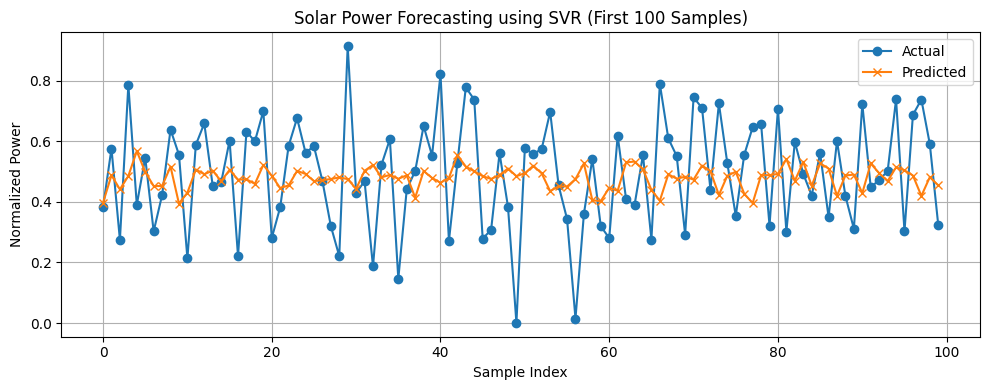

In [15]:
# Step 5: Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Solar Power Forecasting using SVR (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-16-0066359f2bfa>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


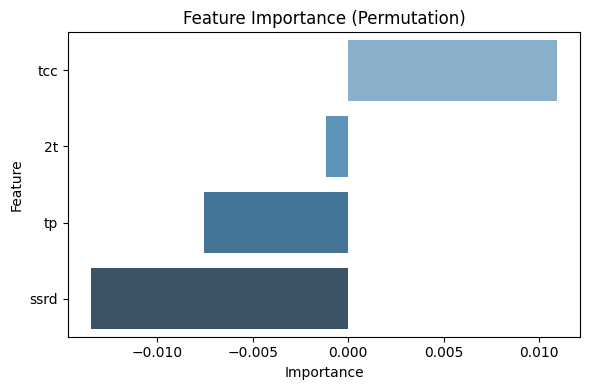

In [16]:
#  Extension 1: Feature Importance via Permutation
result = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
plt.title('Feature Importance (Permutation)')
plt.tight_layout()
plt.show()


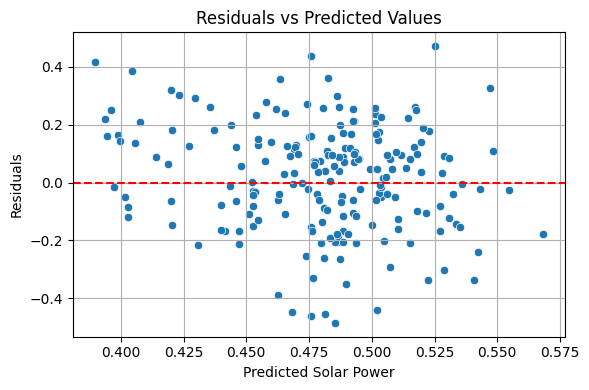

In [17]:
#  Extension 2: Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Solar Power')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

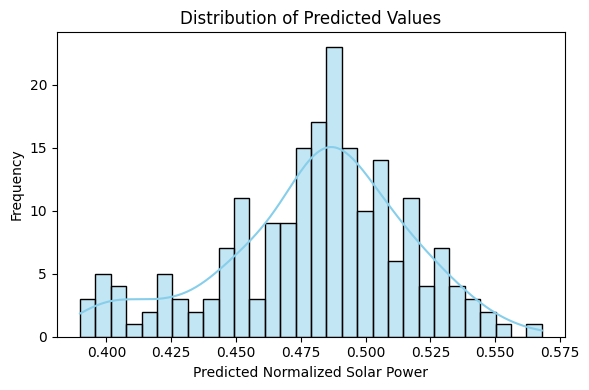

In [18]:
#  Extension 3: Prediction Histogram
plt.figure(figsize=(6, 4))
sns.histplot(y_pred, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Normalized Solar Power')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
